# Installation

 - Run these commands
     
     - git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git
     
     - cd Monk_Object_Detection/7_yolov3/installation
     
 - Select the right requirements file and run
 
     - cat requirements.txt | xargs -n 1 -L 1 pip install

# About the network

1. Paper on Yolov3: https://arxiv.org/abs/1804.02767

2. Paper on Yolov3-SPP: https://arxiv.org/abs/1903.08589

3. Darknet: https://pjreddie.com/darknet/

4. Blog-1 on yolo: https://machinethink.net/blog/object-detection-with-yolo/

5. Blog-2 on yolo: https://medium.com/@jonathan_hui/real-time-object-detection-with-yolo-yolov2-28b1b93e2088

6. Blog-3 on yolo: https://blog.ekbana.com/training-yolov2-in-a-custom-dataset-6fcf58f65fa2

7. Blog-4 on yolo: https://towardsdatascience.com/yolo-v3-object-detection-53fb7d3bfe6b

8. Blog-5 on yolo: https://blog.insightdatascience.com/how-to-train-your-own-yolov3-detector-from-scratch-224d10e55de2

# Monk Format

## Dataset Directory Structure

    ../sample_dataset/kangaroo (root)
          |
          |-----------Images (img_dir)
          |              |
          |              |------------------img1.jpg
          |              |------------------img2.jpg
          |              |------------------.........(and so on)
          |
          |
          |-----------train_labels.csv (anno_file)
          
          
## Annotation file format

           | Id         | Labels                                 |
           | img1.jpg   | x1 y1 x2 y2 label1 x1 y1 x2 y2 label2  |
           
- Labels:  xmin ymin xmax ymax label
- xmin, ymin - top left corner of bounding box
- xmax, ymax - bottom right corner of bounding box

# Required Format - Yolo

## Dataset Directory Structure

    ../sample_dataset/kangaroo (root)
          |
          |-----------Images (img_dir)
          |              |
          |              |------------------img1.jpg
          |              |------------------img2.jpg
          |              |------------------.........(and so on)
          |
          |-----------labels (label_dir)
          |              |
          |              |------------------img1.txt
          |              |------------------img2.txt
          |              |------------------.........(and so on)
          |
          |------------classes.txt 
          

## Classes file
 
     List of classes in every new line.
     The order corresponds to the IDs in annotation files
     
     Eg.
          class1               (------------------------------> if will be 0)
          class2               (------------------------------> if will be 1)
          class3               (------------------------------> if will be 2)
          class4               (------------------------------> if will be 3)
          

## Annotation file format

    CLASS_ID BOX_X_CENTER BOX_Y_CENTER WIDTH BOX_WIDTH BOX_HEIGHT
    
    (All the coordinates should be normalized)
    (X coordinates divided by width of image, Y coordinates divided by height of image)
    
    Ex. (One line per bounding box of object in image)
        class_id x1 y1 w h
        class_id x1 y1 w h
        ..... (and so on)
        

# Data Conversion

In [1]:
import os
import sys

In [2]:
root_dir = "../sample_dataset/ship/";
img_dir = "images/Train";
anno_file = "train_labels.csv";

In [3]:
labels_dir = "labels";
classes_file = "classes.txt";

In [4]:
labels_dir_relative = root_dir + "/" + labels_dir
if(not os.path.isdir(labels_dir_relative)):
    os.mkdir(labels_dir_relative);

In [5]:
import pandas as pd
df = pd.read_csv(root_dir + "/" + anno_file);
len(df)

750

In [7]:
columns = df.columns
classes = [];
for i in range(len(df)):
    img_file = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(" ");
    for j in range(len(tmp)//5):
        label = tmp[j*5 + 4];
        if(label not in classes):
            classes.append(label);
classes = sorted(classes)
classes

['type-0', 'type-1', 'type-2', 'type-3', 'type-4']

In [8]:
f = open(root_dir + "/" + classes_file, 'w');
for i in range(len(classes)):
    f.write(classes[i]);
    f.write("\n");
f.close();

In [9]:
from PIL import Image
from tqdm.notebook import tqdm

In [10]:
for i in tqdm(range(len(df))):
    img_file = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(" ");
    fname = labels_dir_relative + "/" + img_file.split(".")[0] + ".txt";
    img = Image.open(root_dir + "/" + img_dir + "/" + img_file);
    width, height = img.size
    
    f = open(fname, 'w');
    for j in range(len(tmp)//5):
        x1 = float(tmp[j*5 + 0]);
        y1 = float(tmp[j*5 + 1]);
        x2 = float(tmp[j*5 + 2]);
        y2 = float(tmp[j*5 + 3]);
        label = tmp[j*5 + 4];
        
        x_c = str(((x1 + x2)/2)/width);
        y_c = str(((y1 + y2)/2)/height);
        w = str((x2 - x1)/width);
        h = str((y2 - y1)/height);
        index = str(classes.index(label));
        
        f.write(index + " " + x_c + " " + y_c + " " + w + " " + h);
        f.write("\n");
    f.close();

# Training 

In [11]:
import os
import sys
sys.path.append("../../7_yolov3/lib");

In [12]:
from train_detector import Detector

In [13]:
gtf = Detector();

In [14]:
# With evolving parameters validation data is required
# As an example we re keeping val data same as train

In [15]:
img_dir = "../sample_dataset/ship/images/Train/";
label_dir = "../sample_dataset/ship/labels/";
class_list_file = "../sample_dataset/ship/classes.txt"
gtf.set_train_dataset(img_dir, label_dir, class_list_file, batch_size=2)
gtf.set_val_dataset(img_dir, label_dir)

### Availale model types
- "yolov3";
- "yolov3s";
- "yolov3-spp";
- "yolov3-spp3";
- "yolov3-tiny";
- "yolov3-spp-matrix";
- "csresnext50-panet-spp";

In [16]:
gtf.set_model(model_name="yolov3");

### Hyper-params for evolving params
 - Set evolve as True
 - Set num_generations (Total epochs = num_generations*epochs)
 

### Optimizers
 - "sgd"
 - "adam"

In [18]:
gtf.set_hyperparams(optimizer="sgd", lr=0.00579, multi_scale=False, evolve=True, num_generations=2);

Using CUDA Apex device0 _CudaDeviceProperties(name='GeForce GTX 980 Ti', total_memory=6080MB)



Caching labels (750 found, 0 missing, 0 empty, 0 duplicate, for 750 images): 100%|██████████| 750/750 [00:00<00:00, 6650.25it/s]
Caching labels (750 found, 0 missing, 0 empty, 0 duplicate, for 750 images): 100%|██████████| 750/750 [00:00<00:00, 6942.13it/s]

Model Summary: 222 layers, 6.15453e+07 parameters, 6.15453e+07 gradients
Using 2 dataloader workers
Starting training for 2 epochs...

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


               Class    Images   Targets         P         R   mAP@0.5        F1:   0%|          | 0/188 [00:00<?, ?it/s]

               Class    Images   Targets         P         R   mAP@0.5        F1: 100%|██████████| 188/188 [00:19<00:00,  9.78it/s]
/home/abhi/.virtualenvs/monk_obj_7_yolov3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:113: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


                 all       750  2.19e+03    0.0261    0.0964    0.0212     0.041

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


               Class    Images   Targets         P         R   mAP@0.5        F1:   0%|          | 0/188 [00:00<?, ?it/s]

               Class    Images   Targets         P         R   mAP@0.5        F1: 100%|██████████| 188/188 [00:18<00:00, 10.31it/s]


                 all       750  2.19e+03    0.0318     0.147    0.0599    0.0523
2 epochs completed in 0.067 hours.


      giou       cls    cls_pw       obj    obj_pw     iou_t       lr0       lrf  momentumweight_decay  fl_gamma     hsv_h     hsv_s     hsv_v   degrees translate     scale     shear
      3.54      37.4         1      49.5         1     0.263      0.01        -4     0.937  0.000484       0.5    0.0073       0.9      0.36      1.98      0.05      0.05     0.641
Evolved fitness:     0.0318    0.1465   0.05989   0.05226     4.049     1.705     7.606

           giou: 3.54
            cls: 37.4
         cls_pw: 1
            obj: 49.5
         obj_pw: 1
          iou_t: 0.225
            lr0: 0.00579
            lrf: -4
       momentum: 0.937
   weight_decay: 0.000484
       fl_gamma: 0.5
          hsv_h: 0.0138
          hsv_s: 0.9
          hsv_v: 0.36
        degrees: 1.98
      translate: 0.05
          scale: 0.05
          shear: 0.641
Using CUDA Apex device0 _CudaDe

Caching labels (750 found, 0 missing, 0 empty, 0 duplicate, for 750 images): 100%|██████████| 750/750 [00:00<00:00, 6845.27it/s]
Caching labels (750 found, 0 missing, 0 empty, 0 duplicate, for 750 images): 100%|██████████| 750/750 [00:00<00:00, 6864.22it/s]

Model Summary: 222 layers, 6.15453e+07 parameters, 6.15453e+07 gradients
Using 2 dataloader workers
Starting training for 2 epochs...

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


               Class    Images   Targets         P         R   mAP@0.5        F1:   0%|          | 0/188 [00:00<?, ?it/s]

               Class    Images   Targets         P         R   mAP@0.5        F1: 100%|██████████| 188/188 [00:20<00:00,  9.15it/s]


                 all       750  2.19e+03   0.00273     0.126   0.00905   0.00535

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


               Class    Images   Targets         P         R   mAP@0.5        F1:   0%|          | 0/188 [00:00<?, ?it/s]

               Class    Images   Targets         P         R   mAP@0.5        F1: 100%|██████████| 188/188 [00:19<00:00,  9.82it/s]


                 all       750  2.19e+03    0.0459     0.167    0.0997    0.0721
2 epochs completed in 0.070 hours.


      giou       cls    cls_pw       obj    obj_pw     iou_t       lr0       lrf  momentumweight_decay  fl_gamma     hsv_h     hsv_s     hsv_v   degrees translate     scale     shear
      3.92        24         1      15.3         1     0.225   0.00579        -4     0.937  0.000826       0.5    0.0138     0.486      0.36      1.98      0.05      0.05     0.641
Evolved fitness:    0.04594    0.1672   0.09974   0.07208     3.866    0.5892     3.427

           giou: 3.54
            cls: 37.4
         cls_pw: 1
            obj: 49.5
         obj_pw: 1
          iou_t: 0.225
            lr0: 0.00579
            lrf: -4
       momentum: 0.937
   weight_decay: 0.000484
       fl_gamma: 0.5
          hsv_h: 0.0138
          hsv_s: 0.9
          hsv_v: 0.36
        degrees: 1.98
      translate: 0.05
          scale: 0.05
          shear: 0.641


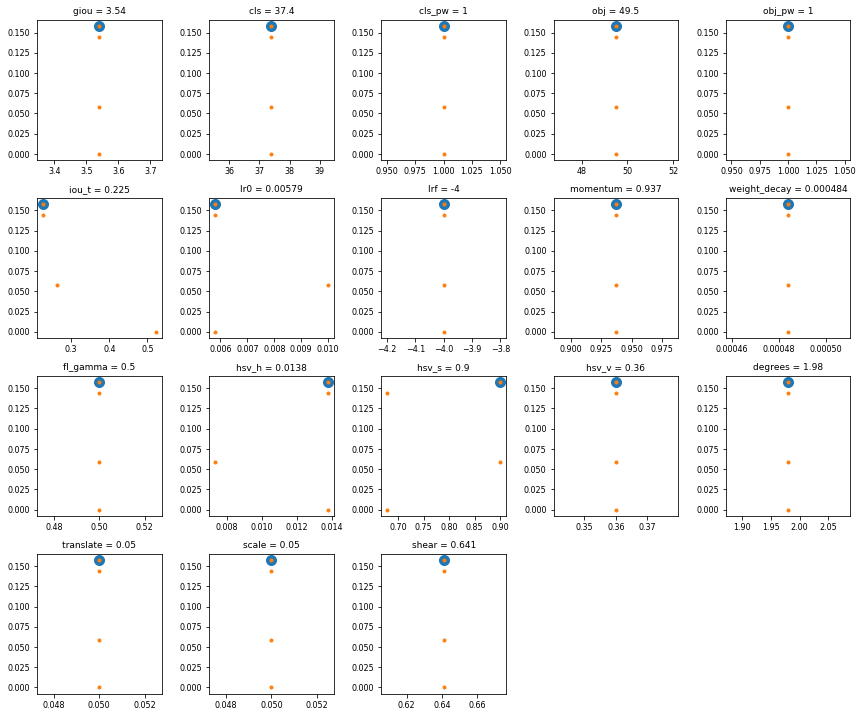

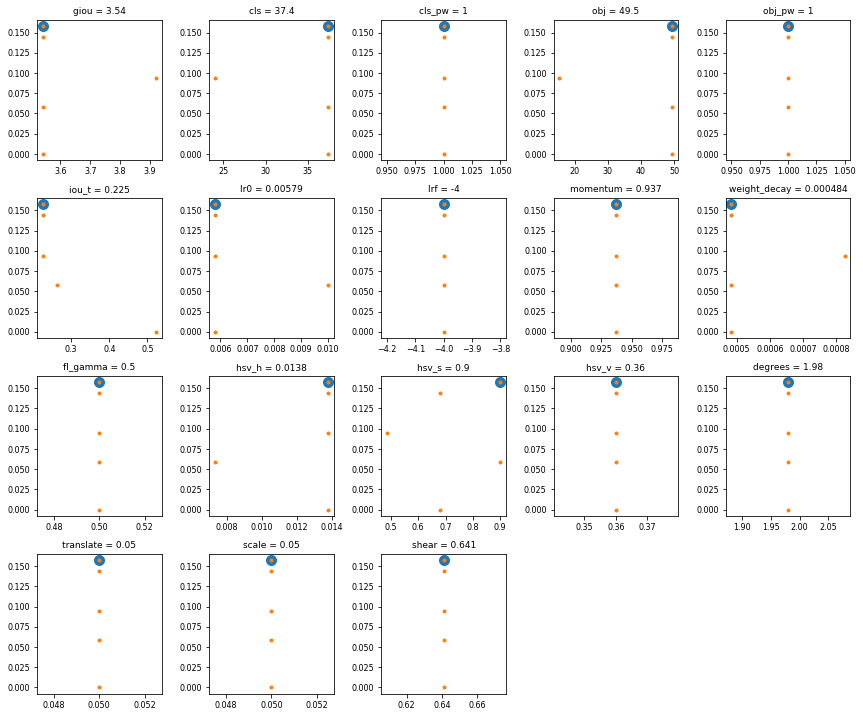

In [19]:
gtf.Train(num_epochs=2);

# Inference

In [1]:
import os
import sys
from IPython.display import Image
sys.path.append("../../7_yolov3/lib");

In [2]:
from infer_detector import Infer

In [3]:
gtf = Infer();

In [4]:
f = open("../sample_dataset/ship/classes.txt");
class_list = f.readlines();
f.close();

In [5]:
model_name = "yolov3";
weights = "weights/last.pt";
gtf.Model(model_name, class_list, weights, use_gpu=True, input_size=416);

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 980 Ti', total_memory=6080MB)



image 1/1 tmp/img1.jpg: 256x416 2 type-3
s, Done. (0.040s)
Results saved to /home/abhi/Desktop/Work/tess_tool/gui/v0.3/obj_det_models/Organization/v0.9_yolov3/example_notebooks/7_yolov3/output
Done. (0.076s)


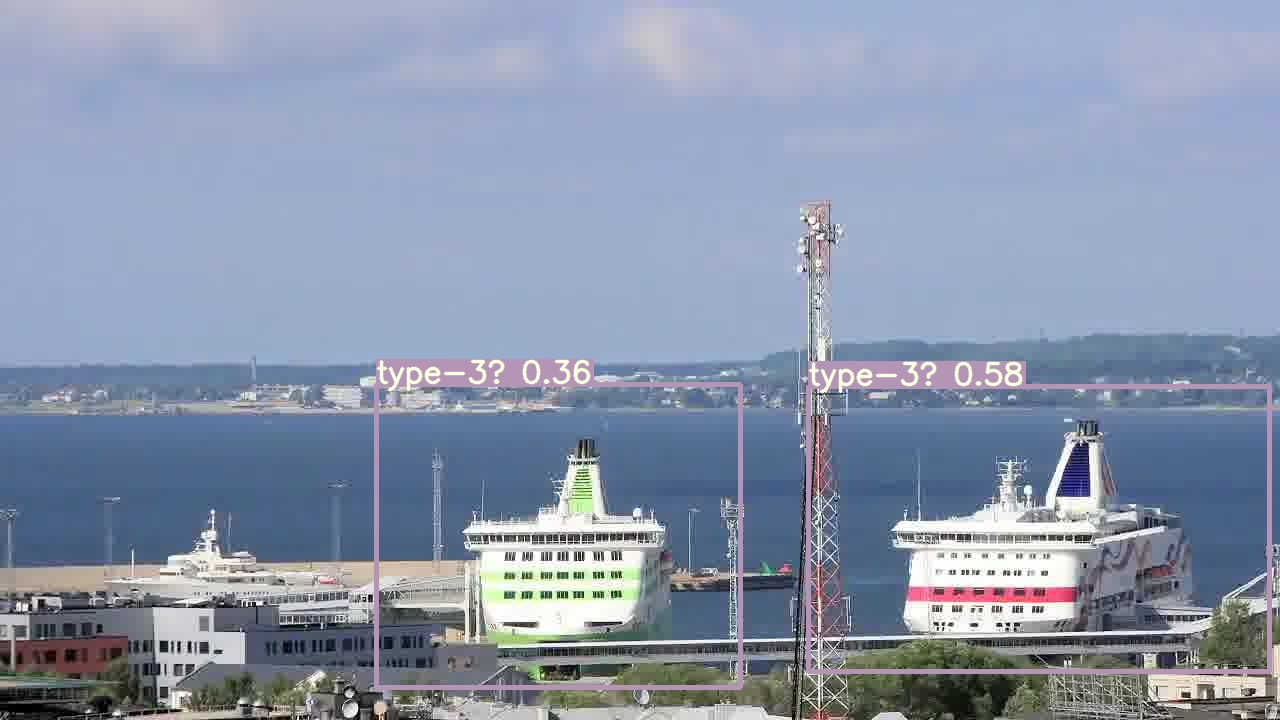

In [6]:
img_path = "../sample_dataset/ship/test/img1.jpg";
gtf.Predict(img_path, conf_thres=0.3, iou_thres=0.5);
Image(filename='output/img1.jpg') 